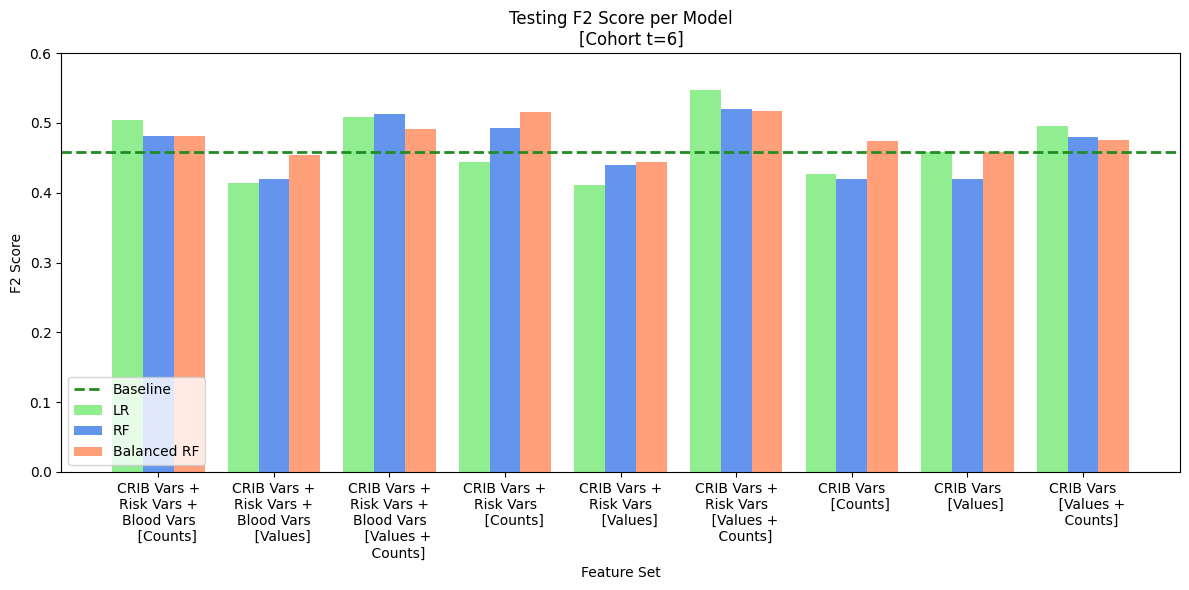

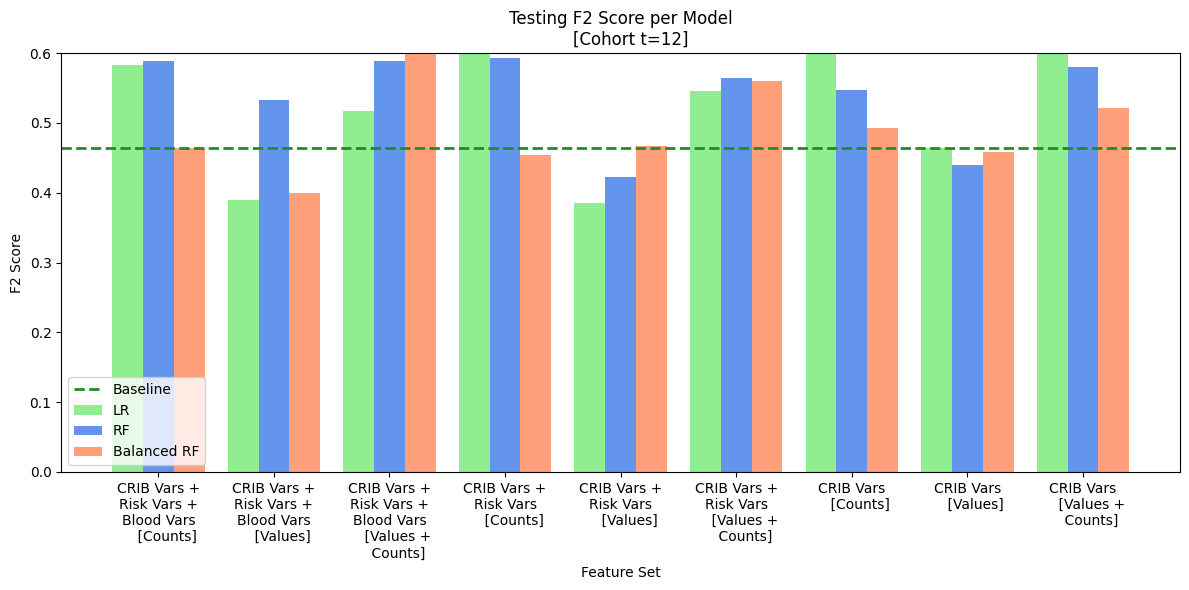

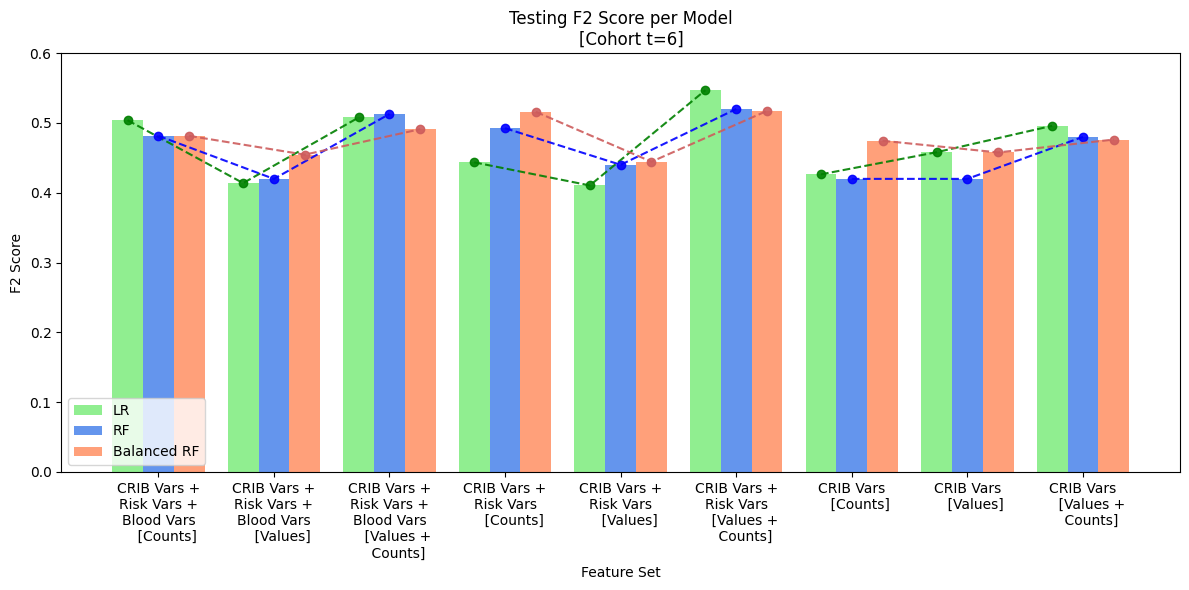

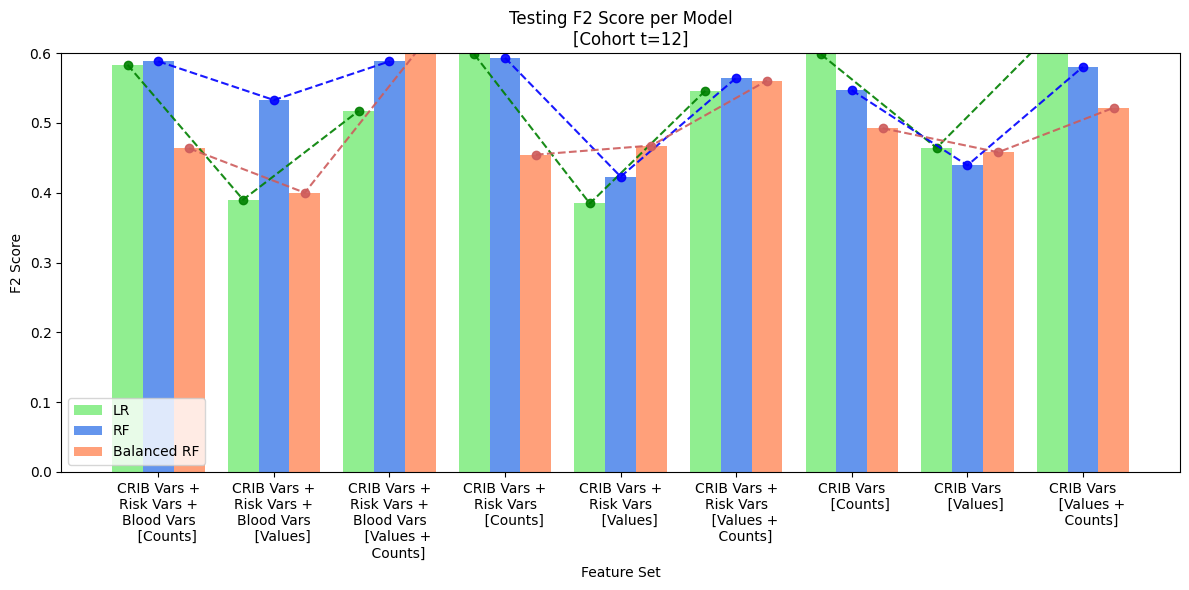

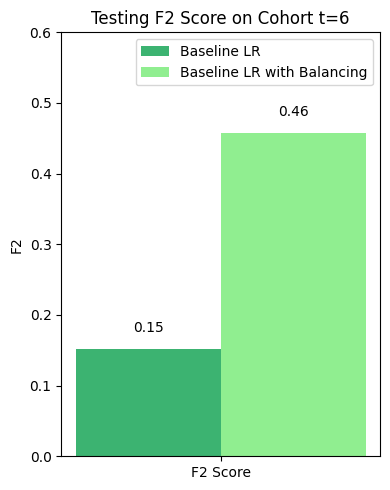

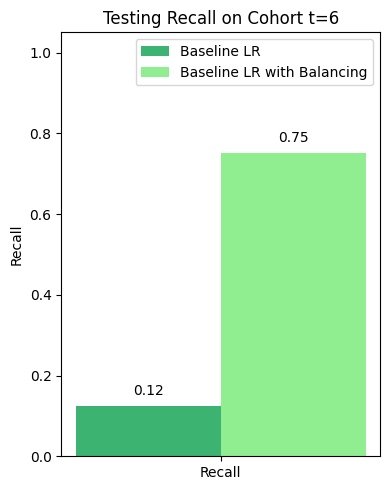

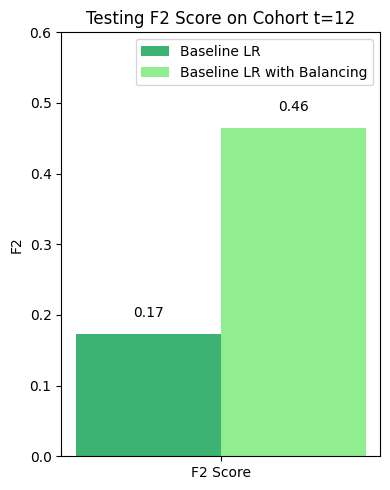

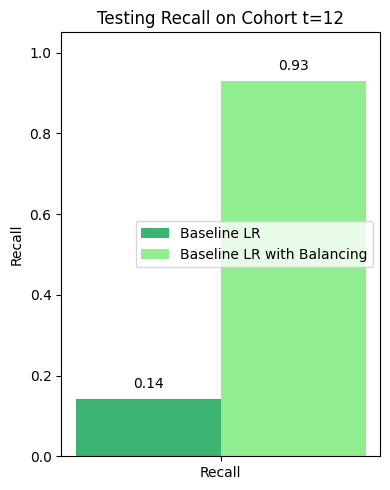

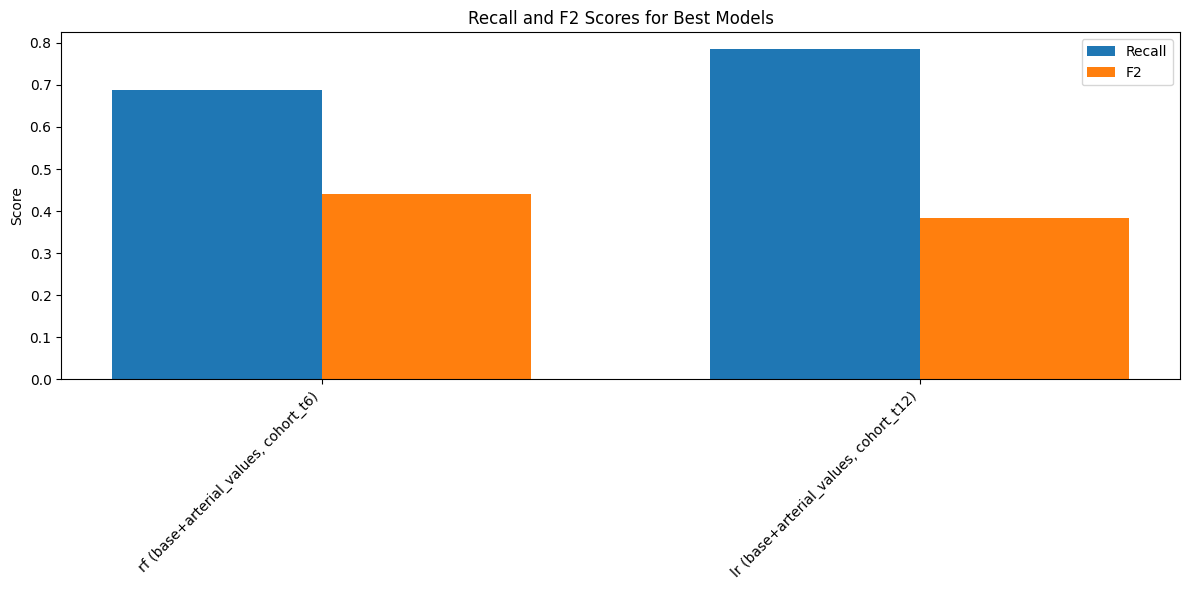

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIG ---
LOG_DIR = "logs"
COHORTS = ["cohort_t6", "cohort_t12"]
BASE_FEATURE_SET = "base_values"  # feature set for baseline comparison

# Mapping for nicer labels
MODEL_LABELS = {
    "baseline_lr": "Baseline LR",
    "lr": "LR",
    "rf": "RF",
    "balanced_rf": "Balanced RF",
}

MODEL_COLORS = {
    "lr": "lightgreen",
    "rf": "cornflowerblue",
    "balanced_rf": "lightsalmon",
    "baseline_lr": "mediumseagreen",
}

MODEL_DARK_COLORS = {
    "lr": "green",
    "rf": "blue",      
    "balanced_rf": "indianred",
}

FEATURE_LABELS = {
    "base_counts": "CRIB Vars [Counts]",
    "base_values": "CRIB Vars [Values]",
    "base_values_counts": "CRIB Vars [Values + Counts]",
    "base+arterial_counts": "CRIB Vars + Risk Vars [Counts]",
    "base+arterial_values": "CRIB Vars + Risk Vars [Values]",
    "base+arterial_values_counts": "CRIB Vars + Risk Vars [Values + Counts]",
    "base+arterial+blood_counts": "CRIB Vars + Risk Vars + Blood Vars [Counts]",
    "base+arterial+blood_values": "CRIB Vars + Risk Vars + Blood Vars [Values]",
    "base+arterial+blood_values_counts": "CRIB Vars + Risk Vars + Blood Vars [Values + Counts]",
}

COHORT_TITLE = {
    "cohort_t6": "Cohort t=6",
    "cohort_t12": "Cohort t=12",
}

# --- HELPER FUNCTION TO LOAD ALL JSON FILES ---
def load_json_logs(cohort_dir):
    data = {}
    feature_sets = [f for f in os.listdir(cohort_dir) if not f.startswith(".")]
    for feature_set in feature_sets:
        feature_path = os.path.join(cohort_dir, feature_set)
        if not os.path.isdir(feature_path):
            continue
        data[feature_set] = {}
        for fname in os.listdir(feature_path):
            if fname.startswith(".") or not fname.endswith(".json"):
                continue  # skip hidden or non-json files
            model_name = fname.replace(".json", "")
            file_path = os.path.join(feature_path, fname)
            with open(file_path) as f:
                json_data = json.load(f)
                # Use testing F2 score
                data[feature_set][model_name] = json_data["testing"]["f2"]
    return data

import re
import textwrap

def wrap_labels_with_brackets(labels, width=20, bracket_indent=4):
    """
    Wrap labels to multiple lines. 
    If there is a [...] portion, it will be indented on the next line.
    """
    wrapped = []
    for label in labels:
        # Detect [...] portion
        match = re.search(r'(\[.*\])', label)
        if match:
            main_text = label[:match.start()].strip()
            bracket_text = match.group(1)
            # Wrap main text
            main_wrapped = '\n'.join(textwrap.wrap(main_text, width=width))
            # Indent bracket portion
            bracket_wrapped = '\n'.join([' ' * bracket_indent + line for line in textwrap.wrap(bracket_text, width=width)])
            full_label = main_wrapped + '\n' + bracket_wrapped
        else:
            full_label = '\n'.join(textwrap.wrap(label, width=width))
        wrapped.append(full_label)
    return wrapped

# --- PLOT 1a: F2 scores for all models (excluding baseline_lr) ---
for cohort in COHORTS:
    cohort_path = os.path.join(LOG_DIR, cohort)
    data = load_json_logs(cohort_path)
    
    feature_sets = list(data.keys())
    models = ['lr', 'rf', 'balanced_rf']
    
    # Find lr base_values F2
    lr_base_f2 = data["base_values"]["lr"]
    lr_color = "forestgreen"

    x = np.arange(len(feature_sets))
    width = 0.8 / len(models)
    
    plt.figure(figsize=(12,6))
    for i, model in enumerate(models):
        color = MODEL_COLORS.get(model, None)
        f2_scores = [data[fset].get(model, 0) for fset in feature_sets]
        plt.bar(x + i*width, f2_scores, width, label=MODEL_LABELS.get(model, model), color=color)

    # Horizontal LR base line
    plt.axhline(lr_base_f2, color=lr_color, linestyle="--", linewidth=2, label="Baseline")

    # Wrap labels with brackets indented
    wrapped_labels = wrap_labels_with_brackets([FEATURE_LABELS.get(f, f) for f in feature_sets], width=15)
    
    plt.xticks(x + width*(len(models)-1)/2, wrapped_labels, rotation=0, ha='center')
    plt.ylabel("F2 Score")
    plt.xlabel("Feature Set")
    plt.title(f"Testing F2 Score per Model\n    [{COHORT_TITLE[cohort]}]")
    plt.legend(loc='lower left')
    plt.ylim(0, 0.6)
    plt.tight_layout()
    plt.show()

# --- PLOT 1b: F2 scores with colored bars and connecting lines ---
for cohort in COHORTS:
    cohort_path = os.path.join(LOG_DIR, cohort)
    data = load_json_logs(cohort_path)
    
    feature_sets = list(data.keys())
    models = ['lr', 'rf', 'balanced_rf']

    x = np.arange(len(feature_sets))
    width = 0.8 / len(models)
    
    plt.figure(figsize=(12,6))
    bar_positions = {}
    
    for i, model in enumerate(models):
        color = MODEL_COLORS.get(model, None)
        f2_scores = [data[fset].get(model, 0) for fset in feature_sets]
        bars = plt.bar(x + i*width, f2_scores, width, label=MODEL_LABELS.get(model, model), color=color)
        bar_positions[model] = [bar.get_height() for bar in bars]
    
    # Group feature sets
    feature_groups = {}
    for idx, fset in enumerate(feature_sets):
        if "base+arterial+blood" in fset:
            group = "base+arterial+blood"
        elif "base+arterial" in fset:
            group = "base+arterial"
        else:
            group = "base"
        feature_groups.setdefault(group, []).append(idx)
    
    # Connecting lines with darker colors
    for i, model in enumerate(models):
        line_color = MODEL_DARK_COLORS.get(model, 'black')
        for group, indices in feature_groups.items():
            x_coords = x[indices] + i*width
            y_coords = [bar_positions[model][idx] for idx in indices]
            plt.plot(x_coords, y_coords, linestyle='--', marker='o', color=line_color, alpha=0.9)
    
    # Wrap labels with brackets indented
    wrapped_labels = wrap_labels_with_brackets([FEATURE_LABELS.get(f, f) for f in feature_sets], width=15)
    
    plt.xticks(x + width*(len(models)-1)/2, wrapped_labels, rotation=0, ha='center')
    plt.ylabel("F2 Score")
    plt.xlabel("Feature Set")
    plt.title(f"Testing F2 Score per Model\n    [{COHORT_TITLE[cohort]}]")
    plt.legend(loc='lower left')
    plt.ylim(0, 0.6)
    plt.tight_layout()
    plt.show()

# --- PLOT 2: Separate F2 and Recall plots per cohort, side-by-side bars ---
for cohort in COHORTS:
    cohort_path = os.path.join(LOG_DIR, cohort, BASE_FEATURE_SET)
    
    # Load JSON data
    with open(os.path.join(cohort_path, "baseline_lr.json")) as f:
        baseline = json.load(f)["testing"]
    with open(os.path.join(cohort_path, "lr.json")) as f:
        lr = json.load(f)["testing"]
    
    models = ["baseline_lr", "lr"]
    f2_scores = [baseline["f2"], lr["f2"]]
    recall_scores = [baseline["recall_died"], lr["recall_died"]]
    
    x = np.arange(1)  # only one group per cohort
    width = 0.35      # width of each bar
    
    # --- Plot F2 ---
    plt.figure(figsize=(4,5))
    bars1 = plt.bar(x - width/2, [f2_scores[0]], width, color=MODEL_COLORS[models[0]], label="Baseline LR")
    bars2 = plt.bar(x + width/2, [f2_scores[1]], width, color=MODEL_COLORS[models[1]], label="Baseline LR with Balancing")
    
    plt.xticks(x, ["F2 Score"])
    plt.ylim(0, 0.6)
    plt.ylabel("F2")
    plt.title(f"Testing F2 Score on {COHORT_TITLE[cohort]}")
    
    # Add values above bars
    for bar, score in zip(bars1 + bars2, f2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{score:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Plot Recall ---
    plt.figure(figsize=(4,5))
    bars1 = plt.bar(x - width/2, [recall_scores[0]], width, color=MODEL_COLORS[models[0]], label="Baseline LR")
    bars2 = plt.bar(x + width/2, [recall_scores[1]], width, color=MODEL_COLORS[models[1]], label="Baseline LR with Balancing")
    
    plt.xticks(x, ["Recall"])
    plt.ylim(0, 1.05)
    plt.ylabel("Recall")
    plt.title(f"Testing Recall on {COHORT_TITLE[cohort]}")
    
    # Add values above bars
    for bar, score in zip(bars1 + bars2, recall_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{score:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# --- PLOT 3: Recall & F2 for best models subset ---
# Example subset of best models (customize as needed)
BEST_MODELS = [
    {"cohort": "cohort_t6", "feature": "base+arterial_values", "model": "rf"},
    {"cohort": "cohort_t12", "feature": "base+arterial_values", "model": "lr"},
]

recall_scores = []
f2_scores = []
labels = []

for item in BEST_MODELS:
    cohort_path = os.path.join(LOG_DIR, item["cohort"], item["feature"], f"{item['model']}.json")
    with open(cohort_path) as f:
        data = json.load(f)
        recall = data["testing"]["recall_died"]
        f2 = data["testing"]["f2"]
        recall_scores.append(recall)
        f2_scores.append(f2)
        labels.append(f"{item['model']} ({item['feature']}, {item['cohort']})")

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(x - width/2, recall_scores, width, label="Recall")
plt.bar(x + width/2, f2_scores, width, label="F2")
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Recall and F2 Scores for Best Models")
plt.legend()
plt.tight_layout()
plt.show()


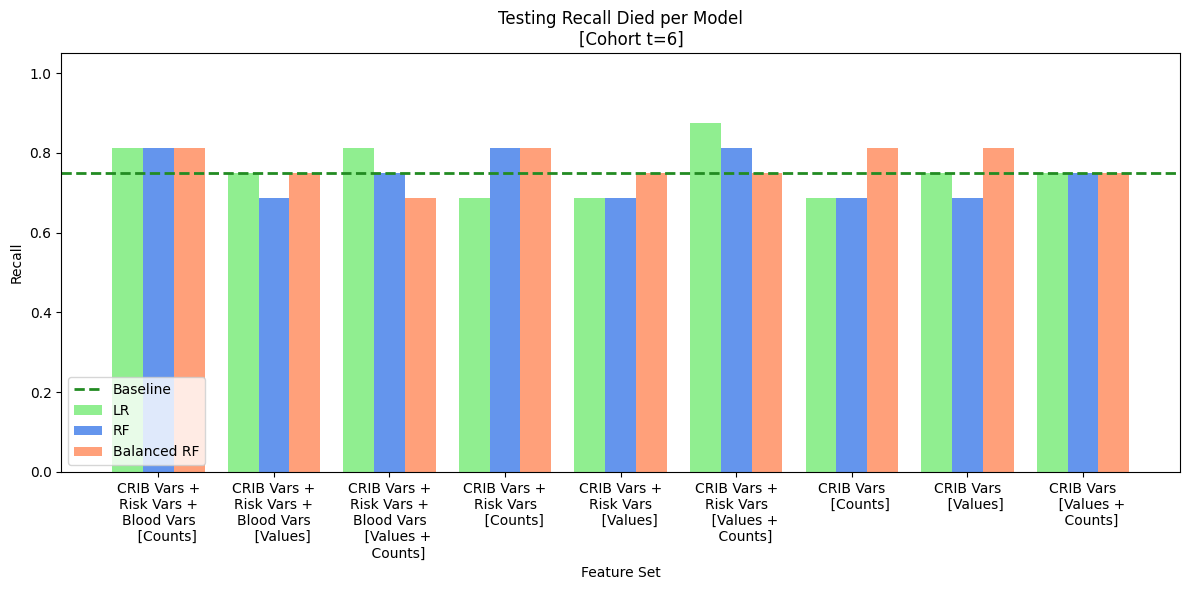

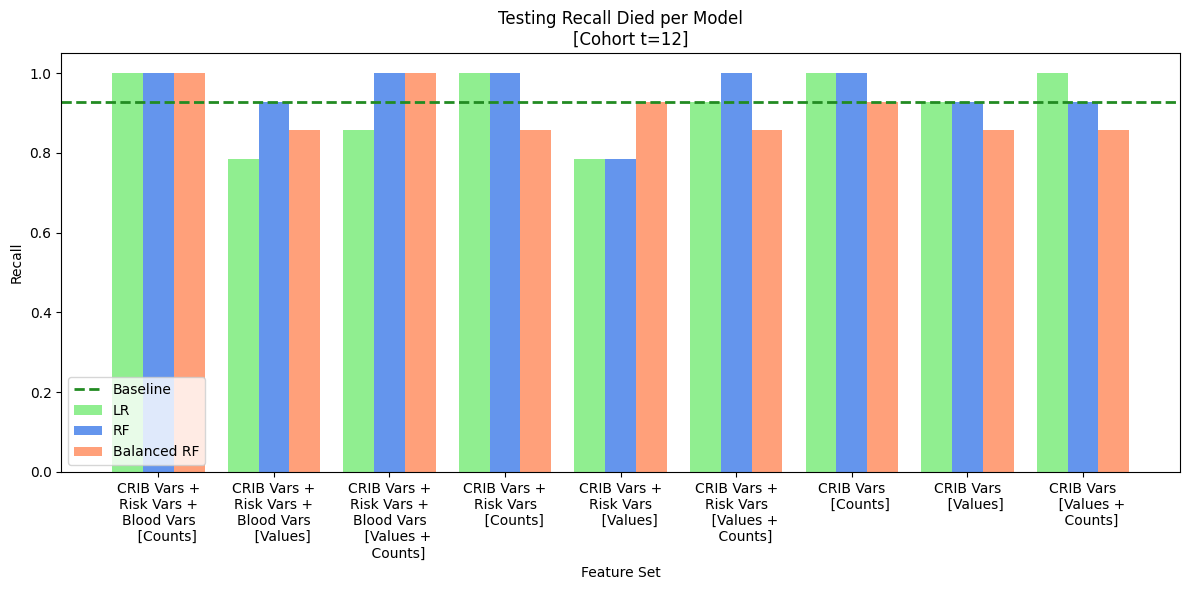

In [2]:
# --- HELPER FUNCTION TO LOAD ALL JSON FILES ---
def load_json_logs_recall(cohort_dir):
    data = {}
    feature_sets = [f for f in os.listdir(cohort_dir) if not f.startswith(".")]
    for feature_set in feature_sets:
        feature_path = os.path.join(cohort_dir, feature_set)
        if not os.path.isdir(feature_path):
            continue
        data[feature_set] = {}
        for fname in os.listdir(feature_path):
            if fname.startswith(".") or not fname.endswith(".json"):
                continue  # skip hidden or non-json files
            model_name = fname.replace(".json", "")
            file_path = os.path.join(feature_path, fname)
            with open(file_path) as f:
                json_data = json.load(f)
                # Use testing F2 score
                data[feature_set][model_name] = json_data["testing"]["recall_died"]
    return data
    
# --- PLOT 1a: F2 scores for all models (excluding baseline_lr) ---
for cohort in COHORTS:
    cohort_path = os.path.join(LOG_DIR, cohort)
    data = load_json_logs_recall(cohort_path)
    
    feature_sets = list(data.keys())
    models = ['lr', 'rf', 'balanced_rf']
    
    # Find lr base_values F2
    lr_base_f2 = data["base_values"]["lr"]
    lr_color = "forestgreen"

    x = np.arange(len(feature_sets))
    width = 0.8 / len(models)
    
    plt.figure(figsize=(12,6))
    for i, model in enumerate(models):
        color = MODEL_COLORS.get(model, None)
        f2_scores = [data[fset].get(model, 0) for fset in feature_sets]
        plt.bar(x + i*width, f2_scores, width, label=MODEL_LABELS.get(model, model), color=color)

    # Horizontal LR base line
    plt.axhline(lr_base_f2, color=lr_color, linestyle="--", linewidth=2, label="Baseline")

    # Wrap labels with brackets indented
    wrapped_labels = wrap_labels_with_brackets([FEATURE_LABELS.get(f, f) for f in feature_sets], width=15)
    
    plt.xticks(x + width*(len(models)-1)/2, wrapped_labels, rotation=0, ha='center')
    plt.ylabel("Recall")
    plt.xlabel("Feature Set")
    plt.title(f"Testing Recall Died per Model\n    [{COHORT_TITLE[cohort]}]")
    plt.legend(loc='lower left')
    plt.ylim(0,1.05)
    plt.tight_layout()
    plt.show()

In [3]:
import os
import json
import pandas as pd

# --- HELPER FUNCTION TO LOAD ALL JSON FILES ---
def load_json_logs(cohort_dir):
    data = []
    feature_sets = [f for f in os.listdir(cohort_dir) if not f.startswith(".")]
    for feature_set in feature_sets:
        feature_path = os.path.join(cohort_dir, feature_set)
        if not os.path.isdir(feature_path):
            continue
        for fname in os.listdir(feature_path):
            if fname.startswith(".") or not fname.endswith(".json"):
                continue
            model_name = fname.replace(".json", "")
            file_path = os.path.join(feature_path, fname)
            with open(file_path) as f:
                json_data = json.load(f)
                f2 = json_data["testing"]["f2"]
                recall = json_data["testing"]["recall_died"]
                data.append({
                    "model": model_name,
                    "feature_set": feature_set,
                    "F2": f2,
                    "Recall": recall
                })
    return pd.DataFrame(data)

# --- RANKING AND DISPLAY ---
for cohort in COHORTS:
    print(f"\n--- Rankings for {COHORT_TITLE[cohort]} ---")
    df = load_json_logs(os.path.join(LOG_DIR, cohort))
    
    # Map nicer labels
    df["Model"] = df["model"].map(MODEL_LABELS)
    df["Feature Set"] = df["feature_set"].map(FEATURE_LABELS)
    
    # Rank by Recall
    recall_ranking = df.sort_values(by="Recall", ascending=False)
    print("\nTop by Recall:")
    for idx, row in recall_ranking.iterrows():
        print(f"{row['Model']} ({row['Feature Set']}): Recall = {row['Recall']:.3f}, F2 = {row['F2']:.3f}")
    
    # Rank by F2
    f2_ranking = df.sort_values(by="F2", ascending=False)
    print("\nTop by F2:")
    for idx, row in f2_ranking.iterrows():
        print(f"{row['Model']} ({row['Feature Set']}): F2 = {row['F2']:.3f}, Recall = {row['Recall']:.3f}")



--- Rankings for Cohort t=6 ---

Top by Recall:
LR (CRIB Vars + Risk Vars [Values + Counts]): Recall = 0.875, F2 = 0.547
Balanced RF (CRIB Vars + Risk Vars + Blood Vars [Counts]): Recall = 0.812, F2 = 0.481
RF (CRIB Vars + Risk Vars + Blood Vars [Counts]): Recall = 0.812, F2 = 0.481
LR (CRIB Vars + Risk Vars + Blood Vars [Counts]): Recall = 0.812, F2 = 0.504
Balanced RF (CRIB Vars [Values]): Recall = 0.812, F2 = 0.458
LR (CRIB Vars + Risk Vars + Blood Vars [Values + Counts]): Recall = 0.812, F2 = 0.508
RF (CRIB Vars + Risk Vars [Counts]): Recall = 0.812, F2 = 0.492
Balanced RF (CRIB Vars + Risk Vars [Counts]): Recall = 0.812, F2 = 0.516
RF (CRIB Vars + Risk Vars [Values + Counts]): Recall = 0.812, F2 = 0.520
Balanced RF (CRIB Vars [Counts]): Recall = 0.812, F2 = 0.474
Balanced RF (CRIB Vars + Risk Vars [Values + Counts]): Recall = 0.750, F2 = 0.517
Balanced RF (CRIB Vars + Risk Vars + Blood Vars [Values]): Recall = 0.750, F2 = 0.455
RF (CRIB Vars + Risk Vars + Blood Vars [Values + Cou